In [1]:
!pip install -q icecream --no-index --find-links=file:///kaggle/input/icecream/  

This is a single model 5folds + 1 full data(6 models actually)     
Spec using torchaudio.stft(gpu) and train with 1 stage using all data(novtes >= 10 with weight 20) for 8 epochs  
Comparing to the model used during competion, the main change is remove duplicate eeg_sub ids with same label, and for each eeg_id + label   choose the middel offset eeg_subid, using it's label(not mean label of eeg_id) and local offset(not middel 10000 of this eeg_id)   
For my model depend on center 50s part it need the exact 50s not the shifted ones.   
Also borrow idea from top solutions and add brain left-right flip and clip -1024,1024 before using filter.  
version1: 8 epochs  
          CV:0.2246 LB:0.235 PB:0.283   
version2: 10 epochs   
          CV:0.2241 LB:0.223 PB:0.286  
version3: 6 epochs  
          CV:0.2231

In [2]:
import numpy as np
import pandas as pd 
from icecream import ic
import cv2
import scipy
from scipy.signal import butter, filtfilt, iirnotch, lfilter, firwin
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import timm
from tqdm.auto import tqdm
from collections.abc import Iterable
from IPython.display import display

In [3]:
MODEL_NAME = 'harmfull-brain-activity'
MIN_VOTES = 10
NAMES = ['LL','RL','LP','RP']
EEG_COLS = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz',
            'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
OTHER_COLS = ['EKG', 'Fz', 'Cz', 'Pz']
TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

class FLAGS:
  root = '../input/hms-harmful-brain-activity-classification'
  model_dir = f'../input/{MODEL_NAME}-model0'
  backbone = 'efficientvit_b2'
  use_specs = True
  use_kaggle_specs = True
  use_eeg_specs = True
  # add raw eeg data to image
  add_raw = True  
  # weather add raw eeg data center 10s to image
  raw_center = True
  strategy = '2.2,8.2,5.1,7'
  strategy2 = '8.2'
  max_specs = 18
  # for each channel the len is 40
  spec_freq = 40
  spec_time = 600
  spec2_freq = 40
  spec2_time = 300
  kaggle_spec_clip = 8
  norm_method = 'clip'
  norm_clip = 18
  # crop central 10s of kaggle spec
  kaggle_crop = True 
  # make the cropped central 10s kaggle spec to 100 so combine original kaggle spec(300, 400) to get shape(400, 400) 
  kaggle_scale = 20.
  center_crop = True
  # lazy spec True means using torchaudio.stf or mel which using gpu while False means using scipy.signal.spectrogram which using cpu
  lazy_spec = True
  center_seconds = 10
  # gstft,gmel for torchaudio, dspec3.1-0-40 for scipy.signal.spectrogram
  eeg_fn = 'gstft'
  low_cut = 0.5
  high_cut = 40
  band_order = 2
  filter_method = '2'
  pre_clip = 1024
  # for torchaudo.stft
  fmin = 0
  fmax = 40
  n_fft = 512
  win_length = 64
  power = 2
  limit_freq = True
  limit_freq_len = True
  time_rate = 1.
  # if False only use ceter 10_000 for each eeg_id
  dynamic_eeg = True
  dynamic_spec = True
  oned_clip = 1024
  oned_base = 1024
  mheads = True
  num_workers = 2
  batch_size = 32
  drop_rate = 0.1
  drop_path_rate = 0.1
  tta = True
  mode = 'test'
  work_mode = 'test'

In [4]:
test = pd.read_csv(f'{FLAGS.root}/test.csv')
test

,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


Util functions

In [5]:
def log_transform(x, exp_min=-4, exp_max=8, logarithm=None):
  x = np.clip(x, np.exp(exp_min), np.exp(exp_max))
  if logarithm == 2:
    x = np.log2(x)
  elif logarithm == 10:
    x = np.log10(x)
  else:
    x = np.log(x)
  return x

def log_normalize(x, clip, clip2=None, logarithm=None, eps=0.1):
  if clip2 is None:
    clip2 = clip
  x = log_transform(x, -clip, clip2, logarithm)
  x /= (max(clip, clip2) + eps)
  return x

def resize(image, shape):
  return cv2.resize(image, (shape[1], shape[0]), interpolation=cv2.INTER_AREA)

def center_crop(X, rate, keep_shape=False, scale=None, shift=0, sample_rate=1):
  width = X.shape[1]
  s = width * ((1 - rate) / 2.)
  s -= shift * sample_rate
  s = int(s)
  e = s + int(width * rate)
  X = X[:, s:e]
  if keep_shape:
    X = resize(X, (X.shape[0], width))
  elif scale:
    X = resize(X, (X.shape[0], int(width * rate * scale)))
  return X

def normalize_image(x):
  if not 'tf_' in FLAGS.backbone:
    # for torch pretrained model, normalize from -1,1 to 0,1
    x = (x + 1.) / 2.
    
  return x

def nan2mean(x):
  m = np.nanmean(x)
  if np.isnan(x).mean() < 1:
    x = np.nan_to_num(x, nan=m)
  else:
    x[:] = 0
  return x

def fixnan(x):
  x = nan2mean(x)
  return x

def norm(spec, method=None, clip=None):
  if not method:
    return spec
  if method == 'none':
    return spec
  if method == 'db':
    spec = librosa.power_to_db(spec, ref=np.max).astype(np.float32)
    spec = (spec + 40) / 40
  elif method == 'clip':
    spec = log_normalize(spec, clip)
  elif method == 'minmax':
    min_ = spec.min()
    max_ = spec.max()
    spec = (spec - min_) / (max_ - min_)
  return spec

global_dict = {}
def Set(key, val):
  global_dict[key] = val
def Get(key):
  return global_dict.get(key, None)

Singal filter

In [6]:
# https://www.kaggle.com/code/konstantinboyko/hms-resnet1d-gru-train-1-5-dataset
def butter_bandpass(lowcut, highcut, fs, order=5):
  return butter(order, [lowcut, highcut], fs=fs, btype="band")

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
  b, a = butter_bandpass(lowcut, highcut, fs, order=order)
  y = lfilter(b, a, data)
  return y

def filter(x, method=None, low_cut=None, high_cut=None, order=None, mode='test'):
  if low_cut is None:
    low_cut = FLAGS.low_cut
    if low_cut == 0:
      low_cut = 0.01
    
  if high_cut is None:
    high_cut = FLAGS.high_cut
    if high_cut == 100:
      high_cut = 99.99
    
  if order is None:
    order = FLAGS.band_order
    
  match method:
    case '1':
      nyquist_freq = 0.5 * 200
      low_cut_freq_normalized = 0.7 / nyquist_freq
      high_cut_freq_normalized = high_cut / nyquist_freq

      # Bandpass and notch filter
      bandpass_coefficients = butter(
          order, [low_cut_freq_normalized, high_cut_freq_normalized], btype='band')
      notch_coefficients = iirnotch(w0=60, Q=30, fs=200)
      x = filtfilt(*notch_coefficients, x)
      x = filtfilt(*bandpass_coefficients, x)
    case '2':
      x = butter_bandpass_filter(x, low_cut, high_cut, 200, order=order)    
  return x

Eeg to spec

In [7]:
def _get_spec(x, eeg_fn, freq_len, time_len, filter_method=None, lazy=False, mode='test'):
  if lazy or FLAGS.lazy_spec:
    if filter_method is None:
      filter_method = FLAGS.filter_method or '2'
    x = filter(x, filter_method)
    x = np.expand_dims(x, 0).astype(np.float32)
    assert x.shape[1] == 10_000, x.shape
    return x
  
  if eeg_fn == '1d':
    filter_method = FLAGS.filter_method or '2'
    x = filter(x, filter_method, mode=mode)
    x = np.clip(x, -FLAGS.oned_clip, FLAGS.oned_clip)
    x /= FLAGS.oned_base
    x = np.expand_dims(x, 0)
    return x
  
  norm_method = FLAGS.norm_method
  norm_clip = FLAGS.norm_clip

  if '_' in eeg_fn:
    eeg_fn, norm_clip = eeg_fn.split('_')
    norm_clip = int(norm_clip)

  min_freq = 0
  max_freq = 100
  if '-' in eeg_fn:
    eeg_fn, min_freq, max_freq = eeg_fn.split('-')
    min_freq, max_freq = float(min_freq), float(max_freq)
    
  low_cut = min_freq
  hight_cut = max_freq

  if eeg_fn == 'stft3.1.4':
    x = filter(x, '2', mode=mode)
    n_fft = (freq_len - 1) * 2
    spec = librosa.stft(x,
                        n_fft=n_fft,
                        win_length=n_fft // 2,
                        hop_length=len(x) // time_len)
    spec = np.abs(spec)
  elif eeg_fn == 'mel6':
    spec = librosa.feature.melspectrogram(y=x,
                                          sr=200,
                                          hop_length=len(x) // time_len,
                                          n_fft=2048,
                                          n_mels=freq_len,
                                          fmin=0,
                                          fmax=20,
                                          win_length=freq_len)
  elif eeg_fn == 'dspec3.1':
    # will run here
    fs = 200
    nperseg = 128
    spec_time = Get('spec_time')
    # noverlap = int(nperseg - 10_000 / spec_time)
    # if 10_000 / (nperseg - noverlap) < spec_time:
    #   noverlap += 1
    match spec_time:
      case 600:
        # output is 618
        noverlap = 112
      case 300:
        noverlap = 96
      case 1000:
        # output is 209 for 2000 input, notie 10000 / (128 - 118) / 5 = 200, but here if set 118 will output 188 TODO
        noverlap = 119
      case _:
        raise ValueError(f'invalid spec_time {spec_time}')
      
    x = filter(x, '2', mode=mode)
    rate = (max_freq - min_freq) / 100
    freq_len_ = 100
    nfft = (freq_len_ - 1) * 2 / rate
    # ic(nfft)
    frequencies, times, spec = scipy.signal.spectrogram(x,
                                                        fs,
                                                        nperseg=nperseg,
                                                        noverlap=noverlap,
                                                        nfft=nfft)    
    n_freqs = 0
    while (n_freqs < freq_len):
      valid_freqs = (frequencies >= min_freq) & (frequencies <= max_freq)
      n_freqs = valid_freqs.sum()
      if max_freq < 100:
        max_freq += 0.1
      else:
        min_freq -= 0.1
    frequencies_filtered = frequencies[valid_freqs]
    spec = spec[valid_freqs, :]
    spec = spec[:freq_len_, :]
    spec = resize(spec, (freq_len, spec.shape[1]))
  else:
    raise ValueError(f'Unknown eeg_fn {eeg_fn}')

  spec = spec[:, :time_len]
  spec = norm(spec, norm_method, norm_clip)
  return spec

In [8]:
# https://www.learningeeg.com/montages-and-technical-components
def eeg2spec(eeg, eeg_fn, freq_len, time_len, eeg_strategy=0, eeg_channels=[], filter_method=None, lazy=False, mode='test'):
  imgs = []
  def _get_part(COLS):
    # img = np.zeros((freq_len, time_len), dtype='float32')
    img = None
    COLS2 = COLS[1:]
    COLS = COLS[:-1]
    for kk in range(len(COLS)):
      x = eeg[COLS[kk]].values - eeg[COLS2[kk]].values
      x = fixnan(x)
      spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
      if img is None:
        img = spec
      else:
        img += spec
    img /= len(COLS)
    imgs.append(img)
    
  def _get_part2(COLS):
    COLS2 = COLS[1:]
    COLS = COLS[:-1]
    for kk in range(len(COLS)):
      x = eeg[COLS[kk]].values - eeg[COLS2[kk]].values
      x = fixnan(x)
      spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
      imgs.append(spec)
      
  def _get_part2_2(COLS):
    COLS2 = COLS[1:]
    COLS = COLS[:-1]
    img = None
    for kk in range(len(COLS)):
      x = eeg[COLS[kk]].values - eeg[COLS2[kk]].values
      x = fixnan(x)
      spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
      imgs.append(spec)
      if img is None:
        img = spec
      else:
        img += spec
    img /= len(COLS)
    imgs.append(img)
      
  def _get_part3(COLS):
    COLS2 = COLS[1:]
    COLS = COLS[:-1]
    specs = {}
    for kk in range(len(COLS)):
      for col in [COLS[kk], COLS2[kk]]:
        if not col in specs:
          x = eeg[col].values
          x = fixnan(x)
          x = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
          specs[col] = x
      spec = specs[COLS[kk]] - specs[COLS2[kk]]
      # to -1,1
      spec /= 2.
      imgs.append(spec)
      
  def _get_parts4(COLS1, COLS2):
    for col1, col2 in zip(COLS1, COLS2):
      x = eeg[col1].values - eeg[col2].values
      x = fixnan(x)
      spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
      imgs.append(spec)
  
  if eeg_strategy == '0':
    # 4象限 双香蕉，但是少 cz fz pz 中间区域象限
    FEATS = [['Fp1', 'F7', 'T3', 'T5', 'O1'], 
             ['Fp2', 'F8', 'T4', 'T6', 'O2'],
             ['Fp1', 'F3', 'C3', 'P3', 'O1'], 
             ['Fp2', 'F4', 'C4', 'P4', 'O2']]

    for k in range(4):
      img = np.zeros((freq_len, time_len), dtype='float32')
      COLS = FEATS[k]
      for kk in range(4):

        # COMPUTE PAIR DIFFERENCES
        x = eeg[COLS[kk]].values - eeg[COLS[kk + 1]].values
        x = fixnan(x)
        spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
        img += spec

      img /= 4.0
      imgs.append(img)
  elif eeg_strategy == '1':
    # 直接encode各个channel 特别的encode 心电图EKG
    if eeg_channels == ['all']:
      eeg_channels = []
    if eeg_channels == ['others']:
      eeg_channels = OTHER_COLS
    cols = eeg_channels or eeg.columns
    # ic(cols)
    for col in cols:
      x = eeg[col].values
      x = fixnan(x)
      spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
      imgs.append(spec)
  elif eeg_strategy == '2':
    # 5象限 完整双香蕉
    FEATS = [['Fp1', 'F7', 'T3', 'T5', 'O1'], 
             ['Fp2', 'F8', 'T4', 'T6', 'O2'],
             ['Fp1', 'F3', 'C3', 'P3', 'O1'], 
             ['Fp2', 'F4', 'C4', 'P4', 'O2']]

    for k in range(4):
      img = None
      COLS = FEATS[k]
      for kk in range(4):

        # COMPUTE PAIR DIFFERENCES
        x = eeg[COLS[kk]].values - eeg[COLS[kk + 1]].values
        x = fixnan(x)

        spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
        if img is None:
          img = spec
        else:
          img += spec

      img /= 4.
      imgs.append(img)

    COLS = ['Fz', 'Cz', 'Pz']
    img = None
    for kk in range(2):
      x = eeg[COLS[kk]].values - eeg[COLS[kk + 1]].values
      x = fixnan(x)
      spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
      if img is None:
        img = spec
      else:
        img += spec
    img /= 2.
    imgs.append(img)
  elif eeg_strategy == '2.1':
    # 5象限 完整双香蕉,顺序按照标准...
    FEATS = [
             ['Fp1', 'F7', 'T3', 'T5', 'O1'],
             ['Fp1', 'F3', 'C3', 'P3', 'O1'], 
             ['Fz', 'Cz', 'Pz'], 
             ['Fp2', 'F4', 'C4', 'P4', 'O2'],
             ['Fp2', 'F8', 'T4', 'T6', 'O2'],
             ]      
    for COLS in FEATS:
      _get_part(COLS)
  elif eeg_strategy == '2.1.1':
    FEATS = [
          ['Fp1', 'F7', 'T3', 'T5', 'O1'],
          ['Fp1', 'F3', 'C3', 'P3', 'O1'], 
          ['Fz', 'Cz', 'Pz'], 
          ['Fp2', 'F4', 'C4', 'P4', 'O2'],
          ['Fp2', 'F8', 'T4', 'T6', 'O2'],
          ]      
    for COLS in FEATS:
      _get_part(COLS)
    
    x = eeg['EKG'].values  
    x = fixnan(x)
    spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
    imgs.append(spec)   
  elif eeg_strategy == '2.2':
    # 纵向双香蕉 输出18
    FEATS = [
          ['Fp1', 'F7', 'T3', 'T5', 'O1'],
          ['Fp1', 'F3', 'C3', 'P3', 'O1'], 
          ['Fz', 'Cz', 'Pz'], 
          ['Fp2', 'F4', 'C4', 'P4', 'O2'],
          ['Fp2', 'F8', 'T4', 'T6', 'O2'],
          ]      
    for COLS in FEATS:
      _get_part2(COLS) 
  elif eeg_strategy == '2.2.x':
    # 纵向双香蕉 输出19
    FEATS = [
          ['Fp1', 'F7', 'T3', 'T5', 'O1'],
          ['Fp1', 'F3', 'C3', 'P3', 'O1'], 
          ['Fz', 'Cz', 'Pz'], 
          ['Fp2', 'F4', 'C4', 'P4', 'O2'],
          ['Fp2', 'F8', 'T4', 'T6', 'O2'],
          ]      
    for COLS in FEATS:
      _get_part2_2(COLS) 
  elif eeg_strategy == '2.2.0':
    # 纵向双香蕉 no Fz Cz Pz
    FEATS = [
          ['Fp1', 'F7', 'T3', 'T5', 'O1'],
          ['Fp1', 'F3', 'C3', 'P3', 'O1'], 
          ['Fp2', 'F4', 'C4', 'P4', 'O2'],
          ['Fp2', 'F8', 'T4', 'T6', 'O2'],
          ]      
    for COLS in FEATS:
      _get_part2(COLS) 
  elif eeg_strategy == '2.2.1':
    FEATS = [
          ['Fp1', 'F7', 'T3', 'T5', 'O1'],
          ['Fp1', 'F3', 'C3', 'P3', 'O1'], 
          ['Fz', 'Cz', 'Pz'], 
          ['Fp2', 'F4', 'C4', 'P4', 'O2'],
          ['Fp2', 'F8', 'T4', 'T6', 'O2'],
          ]      
    for COLS in FEATS:
      _get_part2(COLS) 
      
    x = eeg['EKG'].values  
    x = fixnan(x)
    spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
    imgs.append(spec)   
  elif eeg_strategy == '2.2.2':
    # 单级模式 相邻求差 类似双香蕉 但是有一点差异... 
    COLS = ['Fp1', 'F7', 'T3', 'T5', 'O1', 'P3', 'C3', 'F3', 'Fz', 'Fp2', 'F8', 'T4', 'T6', 'O2', 'P4', 'C4', 'F4', 'Cz', 'Pz']
    _get_part2(COLS)
  elif eeg_strategy == '2.3':
    FEATS = [
          ['Fp1', 'F7', 'T3', 'T5', 'O1'],
          ['Fp1', 'F3', 'C3', 'P3', 'O1'], 
          ['Fz', 'Cz', 'Pz'], 
          ['Fp2', 'F4', 'C4', 'P4', 'O2'],
          ['Fp2', 'F8', 'T4', 'T6', 'O2'],
          ]      
    for COLS in FEATS:
      _get_part3(COLS) 
  elif eeg_strategy == '3':
    # 圆环模式 输出1个
    COLS = ['Fp1', 'F7', 'T3', 'T5', 'O1', 'O2', 'T6', 'T4', 'F8', 'Fp2']
    COLS2 = COLS[1:] + [COLS[0]]
    img = np.zeros((freq_len, time_len), dtype='float32')
    for kk in range(len(COLS)):
      x = eeg[COLS[kk]].values - eeg[COLS2[kk]].values
      x = fixnan(x)
      spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
      img += spec
    img /= len(COLS)
    imgs.append(img)
  elif eeg_strategy == '4':
    # 平均模式 输出3个
    # 去掉最后的ekg?
    # for avg
    COLS = EEG_COLS[:-1]
    v = eeg[COLS].values
    v = np.nanmean(v, axis=1)
    v = np.nan_to_num(v, nan=0.)
    
    def _get_part(COLS):
      img = np.zeros((freq_len, time_len), dtype='float32')
      for kk in range(len(COLS)):
        x = eeg[COLS[kk]].values - v
        x = fixnan(x)
        spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
        img += spec
      img /= len(COLS)
      imgs.append(img)

    # left
    COLS = ['Fp1', 'F7', 'T3', 'T5', 'O1', 'F3', 'C3', 'P3']
    _get_part(COLS)
    # center
    COLS = ['Fz', 'Cz', 'Pz']
    _get_part(COLS)
    # right
    COLS = ['Fp2', 'F8', 'T4', 'T6', 'O2', 'F4', 'C4', 'P4']
    _get_part(COLS)
  elif eeg_strategy == '4.x':
    # 平均模式 输出3个
    # 去掉最后的ekg?
    # for avg
    COLS = EEG_COLS[:-1]
    v = eeg[COLS].values
    v = np.nanmean(v, axis=1)
    v = np.nan_to_num(v, nan=0.)

    def _get_part(COLS):
      for kk in range(len(COLS)):
        x = eeg[COLS[kk]].values - v
        x = fixnan(x)
        spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
        imgs.append(spec)
        
    # left
    COLS = ['Fp1', 'F7', 'T3', 'T5', 'O1', 'F3', 'C3', 'P3']
    _get_part(COLS)
    # center
    COLS = ['Fz', 'Cz', 'Pz']
    _get_part(COLS)
    # right
    COLS = ['Fp2', 'F8', 'T4', 'T6', 'O2', 'F4', 'C4', 'P4']
    _get_part(COLS)
  elif eeg_strategy == '4.y':
    # 平均模式 输出3个
    # 去掉最后的ekg?
    # for avg
    COLS = EEG_COLS[:-1]
    v = eeg[COLS].values
    v = np.nanmean(v, axis=1)
    v = np.nan_to_num(v, nan=0.)
    
    def _get_part(COLS):
      img = None
      for kk in range(len(COLS)):
        x = eeg[COLS[kk]].values - v
        x = fixnan(x)
        spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
        if img is None:
          img = spec
        else:
          img += spec
      img /= len(COLS)
      imgs.append(img)
      
    FEATS = [
          ['Fp1', 'F7', 'T3', 'T5', 'O1'],
          ['Fp1', 'F3', 'C3', 'P3', 'O1'], 
          ['Fz', 'Cz', 'Pz'], 
          ['Fp2', 'F4', 'C4', 'P4', 'O2'],
          ['Fp2', 'F8', 'T4', 'T6', 'O2'],
          ]     

    for COLS in FEATS:
      _get_part(COLS)
  elif eeg_strategy == '4.1':
    # 平均模式 输出3个, 中心取Cz 而不是平均
    # 去掉最后的ekg?
    # for avg
    v = eeg['Cz'].values

    def _get_part(COLS):
      img = np.zeros((freq_len, time_len), dtype='float32')
      for kk in range(len(COLS)):
        x = eeg[COLS[kk]].values - v
        x = fixnan(x)
        spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
        img += spec
      img /= len(COLS)
      imgs.append(img)
        
    # left
    COLS = ['Fp1', 'F7', 'T3', 'T5', 'O1', 'F3', 'C3', 'P3']
    _get_part(COLS)
    # center
    COLS = ['Fz', 'Cz', 'Pz']
    _get_part(COLS)
    # right
    COLS = ['Fp2', 'F8', 'T4', 'T6', 'O2', 'F4', 'C4', 'P4']
    _get_part(COLS)
  elif eeg_strategy == '4.1.x':
    # 平均模式 输出3个, 中心取Cz 而不是平均
    # 去掉最后的ekg?
    # for avg
    v = eeg['Cz'].values
    
    def _get_part(COLS):
      for kk in range(len(COLS)):
        x = eeg[COLS[kk]].values - v
        x = fixnan(x)
        spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
        imgs.append(spec)

    # left
    COLS = ['Fp1', 'F7', 'T3', 'T5', 'O1', 'F3', 'C3', 'P3']
    _get_part(COLS)
    # center
    COLS = ['Fz', 'Cz', 'Pz']
    _get_part(COLS)
    # right
    COLS = ['Fp2', 'F8', 'T4', 'T6', 'O2', 'F4', 'C4', 'P4']
    _get_part(COLS)
  elif eeg_strategy == '5':
    # 横向模式 输出5个
    COLS = ['Fp1', 'Fp2']
    _get_part(COLS)
    COLS = ['F7', 'F3', 'Fz', 'F4', 'F8']
    _get_part(COLS)
    COLS = ['T3', 'C3', 'Cz', 'C4', 'T4']
    _get_part(COLS)
    COLS = ['T5', 'P3', 'Pz', 'P4', 'T6']
    _get_part(COLS)
    COLS = ['O1', 'O2']
    _get_part(COLS)
  elif eeg_strategy == '5.1':
    # 横向模式输出19
    FEATS = [
          ['Fp1', 'Fp2'],
          ['F7', 'F3', 'Fz', 'F4', 'F8'], 
          ['T3', 'C3', 'Cz', 'C4', 'T4'], 
          ['T5', 'P3', 'Pz', 'P4', 'T6'],
          ['O1', 'O2'],
          ]      
    for COLS in FEATS:
      _get_part2(COLS) 
  elif eeg_strategy == '6':
    # 5 and 3也就是 横向模式 + 圆环模式
    COLS = ['Fp1', 'Fp2']
    _get_part(COLS)
    COLS = ['F7', 'F3', 'Fz', 'F4', 'F8']
    _get_part(COLS)
    COLS = ['T3', 'C3', 'Cz', 'C4', 'T4']
    _get_part(COLS)
    COLS = ['T5', 'P3', 'Pz', 'P4', 'T6']
    _get_part(COLS)
    COLS = ['O1', 'O2']
    _get_part(COLS)
    COLS = ['Fp1', 'F7', 'T3', 'T5', 'O1', 'O2', 'T6', 'T4', 'F8', 'Fp2']
    COLS2 = COLS[1:] + [COLS[0]]
    img = np.zeros((freq_len, time_len), dtype='float32')
    for kk in range(len(COLS)):
      x = eeg[COLS[kk]].values - eeg[COLS2[kk]].values
      x = fixnan(x)
      spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
      img += spec
    img /= len(COLS)
    imgs.append(img)
  elif eeg_strategy == '7':
    # 单独encode每个channel 但是按双香蕉顺序 
    COLS = ['Fp1', 'F7', 'T3', 'T5', 'O1', 'P3', 'C3', 'F3', 'Fz', 'Fp2', 'F8', 'T4', 'T6', 'O2', 'P4', 'C4', 'F4', 'Cz', 'Pz']
    assert len(COLS) == 19
    assert len(set(COLS)) == 19
    for col in COLS:
      x = eeg[col].values
      x = fixnan(x)
      spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
      imgs.append(spec)
  elif eeg_strategy == '8':
    # 参考模式 输出18个
    COLS = ['F7', 'T3', 'T5', 'Fp1', 'F3', 'C3', 'P3', 'O1', 'Fz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6']
    assert len(COLS) == 18
    v = eeg['Cz'].values
    for col in COLS:
      x = eeg[col].values - v
      x = fixnan(x)
      spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
      imgs.append(spec)
  elif eeg_strategy == '8.1':
    # 参考模式 输出18个
    COLS = ['Fp1', 'F7', 'T3', 'T5', 'O1', 'P3', 'C3', 'F3', 'Fz', 'Fp2', 'F8', 'T4', 'T6', 'O2', 'P4', 'C4', 'F4', 'Pz']
    assert len(COLS) == 18
    v = eeg['Cz'].values
    for col in COLS:
      x = eeg[col].values - v
      x = fixnan(x)
      spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
      imgs.append(spec)
  elif eeg_strategy == '8.2':
    # 参考模式 输出18个
    COLS = ['Fp1', 'F7', 'T3', 'T5', 'O1', 'P3', 'C3', 'F3', 'Fz', 'Fp2', 'F8', 'T4', 'T6', 'O2', 'P4', 'C4', 'F4', 'Pz']
    assert len(COLS) == 18
    
    COLS2 = EEG_COLS[:-1]
    v = eeg[COLS2].values
    v = np.nanmean(v, axis=1)
    v = np.nan_to_num(v, nan=0.)
    
    for col in COLS:
      x = eeg[col].values - v
      x = fixnan(x)
      spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
      imgs.append(spec)
  elif eeg_strategy == '8.3':
    # 参考模式 输出19个
    COLS = ['Fp1', 'F7', 'T3', 'T5', 'O1', 'P3', 'C3', 'F3', 'Fz', 'Fp2', 'F8', 'T4', 'T6', 'O2', 'P4', 'C4', 'F4', 'Pz']
    COLS += ['EKG']
    assert len(COLS) == 19
    
    COLS2 = EEG_COLS[:-1]
    v = eeg[COLS2].values
    v = np.nanmean(v, axis=1)
    v = np.nan_to_num(v, nan=0.)
    
    for col in COLS:
      x = eeg[col].values - v
      x = fixnan(x)
      spec = _get_spec(x, eeg_fn, freq_len, time_len, filter_method, lazy=lazy, mode=mode)
      imgs.append(spec)
  elif eeg_strategy == '1d':
    # 最初的8个减法特征 
    # https://www.kaggle.com/code/medali1992/hms-resnet1d-gru-train?scriptVersionId=163575181
    _get_parts4(['Fp1', 'T3', 'Fp1', 'C3', 'Fp2', 'C4', 'Fp2', 'T4'], 
                ['T3', 'O1', 'C3', 'O1', 'C4', 'O2', 'T4', 'O2'])
  elif eeg_strategy == '1d.1':
    map_features = [
        ("Fp1", "T3"),
        ("T3", "O1"),
        ("Fp1", "C3"),
        ("C3", "O1"),
        ("Fp2", "C4"),
        ("C4", "O2"),
        ("Fp2", "T4"),
        ("T4", "O2"),
        #('Fz', 'Cz'), ('Cz', 'Pz'),
        #'F7', 'F3', 'Cz', 'P4', 'T6'
        #'F8', 'F4', 'Cz', 'P3', 'T5'
        ('F7', 'F3'),
        ('F3', 'Cz'),
        ('Cz', 'P4'),
        ('P4', 'T6'),
        ('F8', 'F4'),
        ('F4', 'Cz'),
        ('Cz', 'P3'),
        ('P3', 'T5'),
    ]
    # _get_parts4(['Fp1', 'T3', 'Fp1', 'C3', 'Fp2', 'C4', 'Fp2', 'T4', 'F7', 'F3', 'Cz', 'P4', 'F8', 'F4', 'Cz', 'P3'], 
    #             ['T3', 'O1', 'C3', 'O1', 'C4', 'O2', 'T4', 'O2', 'F3', 'Cz', 'P4', 'T6', 'F4', 'Cz', 'P3', 'T5'])
    # _get_parts4([x[0] for x in map_features], [x[1] for x in map_features])
    _get_parts4(*zip(*map_features))
  else:
    raise ValueError(f'Unknown eeg_strategy {eeg_strategy}')

  img = np.concatenate(imgs, axis=0)
  return img

EegBuilder

In [9]:
def spectrogram_from_eeg(eeg, strategy, eeg_fn, spec_freq, spec_time, center=False, 
                         filter_method=None, lazy=False, mode='test'):
  if not FLAGS.dynamic_spec:
    # just take middel 10_000 for each eeg id
    middle = (len(eeg) - 10_000) // 2
    eeg = eeg.iloc[middle:middle + 10_000]

  rate = len(eeg) / 10_000
  Set('spec_time', spec_time)
  freq_len, time_len = spec_freq, int(spec_time * rate)
  
  if center:
    Set('spec_time', spec_time * 5)
    # from 50s to 10s
    eeg = eeg.iloc[4000:6000]
  
  img = eeg2spec(eeg,
                 eeg_fn,
                 freq_len,
                 time_len,
                 eeg_strategy=strategy,
                 eeg_channels=[],
                 filter_method=filter_method,
                 lazy=lazy,
                 mode=mode)
  return img

In [10]:
def load_eeg_spectrograms(strategy,
                          eeg_fn,
                          spec_freq,
                          spec_time,
                          eeg_ids=None,
                          eeg_offsets_map=None,
                          mode='train'):
  if ',' in strategy or ',' in eeg_fn:
    strategies = strategy.split(',')
    eeg_fns = eeg_fn.split(',')
    if len(strategies) == 1:
      strategies = strategies * len(eeg_fns)
    elif len(eeg_fns) == 1:
      eeg_fns = eeg_fns * len(strategies)
    if FLAGS.add_raw and (not FLAGS.lazy_spec):
      strategies, eeg_fns = strategies[:1], eeg_fns[:1]
    for i, (strategy, eeg_fn) in enumerate(zip(strategies, eeg_fns)):
      if i == 0:
        eeg_specs = load_eeg_spectrograms(strategy, eeg_fn, spec_freq,
                                          spec_time, eeg_ids, eeg_offsets_map,
                                          mode)
        ks = list(eeg_specs.keys())
      else:
        eeg_specs2 = load_eeg_spectrograms(strategy, eeg_fn, spec_freq,
                                           spec_time, eeg_ids, eeg_offsets_map,
                                           mode)
        for k in tqdm(ks, desc='merge eegs', leave=False):
          eeg_specs[k] = np.concatenate([eeg_specs[k], eeg_specs2[k]], axis=0)
          del eeg_specs2[k]
    return eeg_specs

    eeg_specs = convert(eeg_ids, eeg_offsets_map, strategy, eeg_fn, spec_freq,
                        spec_time, mode)

    return eeg_specs


  return eeg_specs


def convert(eeg_ids,
            eeg_offsets_map,
            strategy,
            eeg_fn,
            spec_freq,
            spec_time,
            mode='train'):
  paths_eegs = glob.glob(f'{FLAGS.root}/{mode}_eegs/*.parquet')
  counter = 0

  def deal(eeg_id, mode):
    parquet_path = f'{FLAGS.root}/{mode}_eegs/{eeg_id}.parquet'
    eeg = pd.read_parquet(parquet_path)
    return spectrogram_from_eeg(eeg, strategy, eeg_fn, spec_freq, spec_time)

  eeg_spec_list = gezi.prun_list(lambda x: deal(x, mode=mode),
                                 eeg_ids,
                                 num_workers=FLAGS.pdl_workers)
  eeg_specs = dict(zip(eeg_ids, eeg_spec_list))
  return eeg_specs


def create_image(spec):
  if len(spec.shape) == 2:
    image = np.stack([spec, spec, spec], axis=-3)
  else:
    image = np.transpose(spec, (2, 0, 1))
  return image


class BaseEEGBuilder():

  def __init__(self):
    self.eeg_specs = {}
    self.eegs = {}
    self.eeg_offsets_map = {}
    self.eeg_ids = None
    self.mode = None

  def load_eeg_specs(self, mode):
    if self.eeg_specs:
      return self.eeg_specs

    self.eeg_specs = load_eeg_spectrograms(FLAGS.eeg_strategy, FLAGS.eeg_fn,
                                           FLAGS.spec_freq, FLAGS.spec_time,
                                           self.eeg_ids, self.eeg_offsets_map,
                                           mode)
    ic(len(self.eeg_specs))
    return self.eeg_specs
  
  def _get_eeg(self, row, idx, mode='test'):
    shift = 0
    if self.eegs:
      eeg = self.eegs[row.eeg_id]
    else:
      mode_ = mode
      if mode_ not in ['train', 'test']:
        mode_ = 'train'
      eeg = pd.read_parquet(f'{FLAGS.root}/{mode_}_eegs/{row.eeg_id}.parquet')
   
    if mode == 'test':
      start = 0
    else:
      start = int(row.eeg_offset * 200)
    
    ## just take middel
    if mode == 'train' and (not FLAGS.dynamic_eeg):
      start = (len(eeg) - 10_000) // 2
    
    eeg = eeg.iloc[start:start + 10_000]
    assert len(eeg) == 10_000, f'{start} {len(eeg)}'
    return eeg, shift

  def _gen_spec(self,
                row,
                idx,
                strategy,
                eeg_fn,
                freq_len,
                time_len,
                filter_method=None,
                lazy=False,
                center=False,
                mode='test'):
    eeg, shift = self._get_eeg(row, idx, mode)
    strategies = strategy.split(',')
    eeg_fns = eeg_fn.split(',')
    if len(eeg_fns) == 1:
      eeg_fns = eeg_fns * len(strategies)
      
    if FLAGS.add_raw and (not FLAGS.lazy_spec) and (not lazy):
      strategies, eeg_fns = strategies[:1], eeg_fns[:1]
    specs = [
        spectrogram_from_eeg(eeg, strategy, eeg_fn, freq_len, time_len, center, 
                             filter_method=filter_method, lazy=lazy, mode=mode)
        for strategy, eeg_fn in zip(strategies, eeg_fns)
    ]
    spec = np.concatenate(specs, axis=0)
    # ic(spec.min(), spec.max(), spec.mean(), spec.std())
    return spec

  def get_eeg_specs(self, row, idx=0, mode='test'):
    X = self._gen_spec(row, idx, FLAGS.strategy, FLAGS.eeg_fn,
                        FLAGS.spec_freq, FLAGS.spec_time, mode=mode)

    return [X]

  def merge_specs(self, kaggle_spec, eeg_spec_list, mode='test'):
    image = None
    if not eeg_spec_list:
      spec = create_image(kaggle_spec)
      if not FLAGS.lazy_spec:
        return spec
      else:
        return {'kaggle': kaggle_spec}
    eeg_spec = np.concatenate(eeg_spec_list, axis=0)
    if kaggle_spec is None:
      spec = create_image(eeg_spec)
      # ic(spec.min(), spec.max(), spec.mean(), spec.std())
      if not FLAGS.lazy_spec:
        return spec
      else:
        return {'eeg': eeg_spec}

    if FLAGS.lazy_spec:
      return {'kaggle': kaggle_spec, 'eeg': eeg_spec}

    width = eeg_spec.shape[1]
    if kaggle_spec.shape[1] < width:
      rate = FLAGS.center_seconds / 50.
      shift = 0 
      X = center_crop(eeg_spec, rate, shift=shift, sample_rate=200)
      cut_shape = (kaggle_spec.shape[0],
                    eeg_spec.shape[1] - kaggle_spec.shape[1])
      if X.shape != cut_shape:
        X = resize(X, cut_shape)
      kaggle_spec = np.concatenate([kaggle_spec, X], axis=1)
      assert kaggle_spec.shape[1] == width

    width = max(kaggle_spec.shape[1], eeg_spec.shape[1])
    if width > kaggle_spec.shape[1]:
      kaggle_spec = resize(kaggle_spec, (kaggle_spec.shape[0], width))
    if width > eeg_spec.shape[1]:
      eeg_spec = resize(eeg_spec, (eeg_spec.shape[0], width))

    # concat on height
    spec = np.concatenate([kaggle_spec, eeg_spec], axis=0)
    image = create_image(spec)
    return image

class EEGBuilder(BaseEEGBuilder):
  def __init__(self):
    super().__init__()
    self.eeg_specs2 = {}

  def load_eeg_specs(self, mode):
    if self.eeg_specs:
      return self.eeg_specs
    # 5 * FLAGS.spec_freq, FLAGS.spec_time
    self.eeg_specs = load_eeg_spectrograms(FLAGS.eeg_strategy, FLAGS.eeg_fn, FLAGS.spec_freq, FLAGS.spec_time, 
                                           self.eeg_ids, self.eeg_offsets_map, mode)
    # 5 * FLAGS.spec_freq, FLAGS.spec_time
    eeg_fn = FLAGS.eeg_fn 
    if eeg_fn == 'spec6':
      eeg_fn = 'spec4'
    # by default using 5
    self.eeg_specs2 = load_eeg_spectrograms(FLAGS.eeg_strategy2, eeg_fn, FLAGS.spec2_freq, FLAGS.spec2_time, 
                                            self.eeg_ids, self.eeg_offsets_map, mode)
    ic(len(self.eeg_specs))
    return self.eeg_specs
  
      
  def get_eeg_specs(self, row, idx=0, mode='test'):
    X = self._gen_spec(row, idx, FLAGS.strategy, FLAGS.eeg_fn, FLAGS.spec_freq, FLAGS.spec_time, mode=mode)
        
    if FLAGS.add_raw and (not FLAGS.lazy_spec):
      eeg = self._gen_spec(row, idx, FLAGS.strategy, FLAGS.eeg_fn, FLAGS.spec_freq, FLAGS.spec_time, lazy=True, mode=mode)
      eeg = np.clip(eeg, -FLAGS.oned_clip, FLAGS.oned_clip)
      eeg /= FLAGS.oned_clip
      if FLAGS.raw_center:
        eeg_center = eeg[...,4000:6000]
        if eeg_center.shape[-1] != X.shape[-1]:
          eeg_center = resize(eeg_center, (eeg_center.shape[-2], X.shape[-1]))
      if eeg.shape[-1] != X.shape[-1]:
        eeg = resize(eeg, (eeg.shape[-2], X.shape[-1]))
      
      X = np.concatenate([eeg_center, eeg, X], axis=0)
      
    X2 = self._gen_spec(row, idx, FLAGS.strategy2, FLAGS.eeg_fn, FLAGS.spec2_freq, FLAGS.spec2_time, mode=mode)
    if FLAGS.center_crop:
      shift = 0
      X2 = center_crop(X2, FLAGS.center_seconds / 50., 
                       shift=shift, sample_rate=200)
    return [X, X2]
  
  def merge_specs(self, kaggle_spec, eeg_spec_list, mode='test'):
    if kaggle_spec is None or not eeg_spec_list:
      return BaseEEGBuilder.merge_specs(self, kaggle_spec, eeg_spec_list)
    
    if FLAGS.lazy_spec:
      return {
        'kaggle': kaggle_spec,
        'eeg': eeg_spec_list[0],
        'eeg2': eeg_spec_list[1],
      }
    
    shape = (kaggle_spec.shape[0], FLAGS.spec_time - kaggle_spec.shape[1])

    if eeg_spec_list[-1].shape != shape:
      eeg_spec_list[-1] = resize(eeg_spec_list[-1], shape)

    kaggle_spec = np.concatenate([kaggle_spec, eeg_spec_list[-1]], axis=1)
    eeg_spec_list = eeg_spec_list[:-1]
    return BaseEEGBuilder.merge_specs(self, kaggle_spec, eeg_spec_list)

Dataset

In [11]:
class TorchDataset(Dataset):
  
  def __init__(self,
               df,
               mode='test'):
    assert mode in ['train', 'eval', 'test', 'valid']
    ic(mode, df)
    self.df = df
    self.mode = mode
  
    self.eeg_builder = EEGBuilder()
    
    # idx = self.rng.integers(len(self))
    idx = 0
    self.show(idx)
    
  def show(self, idx):
    data = self[idx]
    ic(self.mode, data)
    if 'image' in data:
      ic(data['image'].shape)
    if 'eeg' in data:
      ic(data['eeg'].shape)
    
  def __len__(self):
    """
        Denotes the number of batches per epoch.
        """
    return len(self.df)


  def __getitem__(self, index):
    """
        Generate one batch of data.
    #     """    
    y = np.zeros(6, dtype='float32')
    
    start = None
    
    row = self.df.iloc[index]
    row = row.copy()
    idx = 0
    r = 0

    if FLAGS.use_specs:
      #----kaggle specs----
      X = None
      kaggle_spec = None
      if FLAGS.use_kaggle_specs:
        X = np.zeros((400, 300), dtype='float32')
        
        def _get_kaggle_spec(spec_id):
          mode_ = self.mode 
          spec = pd.read_parquet(f'{FLAGS.root}/{mode_}_spectrograms/{spec_id}.parquet')
          spec = spec.to_numpy()[:, 1:]
          return spec
        spec = _get_kaggle_spec(row.spectrogram_id)    
        img = spec[r:r + 300].T
        
        img = log_normalize(img, FLAGS.kaggle_spec_clip)
        img = np.nan_to_num(img, nan=-1.)

        X[:, :img.shape[1]] = img
        kaggle_spec = X
        ic(kaggle_spec.shape)
        if FLAGS.kaggle_crop:
          scale = FLAGS.kaggle_scale
          shift = 0
          X = center_crop(X, FLAGS.center_seconds / 600, scale=scale, shift=shift, sample_rate=0.5)
          kaggle_spec = np.concatenate([kaggle_spec, X], axis=1)
          ic(kaggle_spec.shape)
      
      #----------eeg spectrogram----------
      eeg_spec_list = []
      if FLAGS.use_eeg_specs:
        mode = self.mode 
        eeg_spec_list = self.eeg_builder.get_eeg_specs(row, idx, mode=mode)

    data = {}
    if FLAGS.use_specs:
      if not FLAGS.lazy_spec:
        data['image'] = self.eeg_builder.merge_specs(kaggle_spec, eeg_spec_list)
        data['image'] = data['image'].astype(np.float32)
      else:
        data.update(self.eeg_builder.merge_specs(kaggle_spec, eeg_spec_list))
        for key in ['kaggle', 'eeg', 'eeg2']:
          if key in data:
            data[key] = data[key].astype(np.float32)      

    if 'image' in data:
      data['image'] = normalize_image(data['image'])
      data['image'] = torch.from_numpy(data['image'])
    return data

In [12]:
test_ds = TorchDataset(test, 'test')
ic(len(test_ds))

kwargs = {
        'num_workers': FLAGS.num_workers,
        'pin_memory': False,
        'persistent_workers': True,
        'collate_fn': None,
    }

sampler_test = None
test_dl = torch.utils.data.DataLoader(test_ds,
                                    batch_size=FLAGS.batch_size,
                                    sampler=sampler_test,
                                    **kwargs)

ic| mode: 'test'
    df:    spectrogram_id      eeg_id  patient_id
        0          853520  3911565283        6885
ic| kaggle_spec.shape: (400, 300)
ic| kaggle_spec.shape: (400, 400)
ic| self.mode: 'test'
    data: {'eeg': array([[ 5.2884040e+00,  2.5730545e+01,  4.1673122e+01, ...,
                  -9.9133987e+00, -9.8262434e+00, -9.9258661e+00],
                 [ 1.2334883e+00, -6.6841588e+00, -2.1306601e+01, ...,
                   4.5170069e+00,  2.8317184e+00,  6.6268210e+00],
                 [ 5.7319736e-01,  3.2771632e-02, -2.0750425e+00, ...,
                   1.5659818e+01,  1.8525696e+01,  1.5672341e+01],
                 ...,
                 [ 7.1112933e+00,  2.2135309e+01,  2.3507099e+01, ...,
                  -2.0255524e+01, -1.8237801e+01, -1.0162274e+01],
                 [-6.0965514e-01, -3.2582707e+00, -1.1118801e+01, ...,
                  -2.8130220e+01, -2.4232233e+01, -1.4687529e+01],
                 [-5.5294304e+00, -1.9593414e+01, -3.4562195e+01, ...,
  

SpecModule using torchaudio

In [13]:
from torchvision.transforms import v2
from torchaudio import transforms as T

def tlog_transform(x, exp_min=-4, exp_max=8, logarithm=None):
  x = torch.clamp(x, min=np.exp(exp_min), max=np.exp(exp_max))

  if logarithm == 2:
    x = torch.log2(x)
  elif logarithm == 10:
    x = torch.log10(x)
  else:
    x = torch.log(x)

  return x

def tlog_normalize(x, clip, clip2=None, logarithm=None, eps=0.1):
  if clip2 is None:
    clip2 = clip
  x = tlog_transform(x, -clip, clip2, logarithm)
  x /= (max(clip, clip2) + eps)
  return x

class SpecModule(torch.nn.Module):
  
  def __init__(self,
               freq_len,
               n_fft=None,
               eeg_fn=None,
               sample_rate=200,
               fmin=None,
               fmax=None,
               limit_freq=None,
               limit_freq_len=None,
               *args,
               **kwargs):
    super().__init__(*args, **kwargs)
    
    freq_len = FLAGS.spec_freq if freq_len is None else freq_len
    self.freq_len = freq_len
    self.n_fft_ = FLAGS.n_fft if n_fft is None else n_fft
    self.power = FLAGS.power
    if eeg_fn is None:
      self.eeg_fn = FLAGS.eeg_fn
    else:
      self.eeg_fn = eeg_fn
    self.sample_rate = sample_rate
    self.fmin = fmin if fmin is not None else FLAGS.fmin
    self.fmax = fmax if fmax is not None else FLAGS.fmax
    self.limit_freq = limit_freq if limit_freq is not None else FLAGS.limit_freq
    self.limit_freq_len = limit_freq_len if limit_freq_len is not None else FLAGS.limit_freq_len
      
    self.feature_extractor = None
        
  def create_extractor(self, input_len, time_len, strict, time_rate=1.):
    if self.feature_extractor is not None:
      return
    
    self.time_len = time_len
    self.strict = strict
    hop_length = input_len // int(self.time_len * time_rate)
    n_fft = 0
    win_length = 0
    match self.eeg_fn:
      case 'gmel':
        # mel 必须fp32 spec stft可以fp16
        # if none will be smae as n_fft 但是这样默认值效果不好 设置为 freq_len 效果比较好 或者64
        win_length = FLAGS.win_length
        # win_length = self.freq_len
        n_mels = self.freq_len
        n_fft = self.n_fft_
        fmin = self.fmin
        fmax = self.fmax
        self.feature_extractor = T.MelSpectrogram(
          sample_rate=self.sample_rate,
          n_fft=n_fft,
          win_length=win_length,
          hop_length=hop_length,
          n_mels=n_mels,
          f_min=fmin,
          f_max=fmax,
          power=self.power,
          pad_mode=FLAGS.pad_mode,
          center=True,
          norm='slaney',
          # normalized=True,
        )
      case 'gstft':
        if self.n_fft_ == 0:
          n_fft = (self.freq_len - 1) * 2
        else:
          # output height is (1 + n_fft/2) for example 2048 will output 1025, 1024 will output 513
          n_fft = self.n_fft_
        win_length = n_fft // 2 if FLAGS.win_length == 0 else FLAGS.win_length
        # ic(n_fft, win_length, hop_length, self.power)
        self.feature_extractor = T.Spectrogram(n_fft=n_fft, 
                                               win_length=win_length,
                                               hop_length=hop_length,
                                               power=self.power)
        self.freq_len_ = n_fft // 2 + 1

  def forward(self, x):
    # x: (B,C,T)
    B, _, _ = x.shape
    x = self.feature_extractor(x)
        
    # B, channels, freq_len, time_len
    _, _, freq_len, time_len = x.shape
    if self.eeg_fn == 'gstft':
      if self.limit_freq:
        s = int(self.freq_len_ * (self.fmin / 100))
        e = int(self.freq_len_ * (self.fmax / 100)) + 1
        x = x[:, :, s:e]
      if self.limit_freq_len:
        height = x.shape[-2]
        if height != self.freq_len:
          x = v2.Resize((self.freq_len, x.shape[-1]), antialias=True)(x)
    
    freq_len = x.shape[-2]
    if time_len != self.time_len:
      if self.strict:
        x = v2.Resize((x.shape[-2], self.time_len), antialias=True)(x)
    
    time_len = x.shape[-1]
    x = x.reshape(B, -1, time_len)
    x = tlog_normalize(x, FLAGS.norm_clip)

    return x  

Model

In [14]:
class BaseModel(nn.Module):
  
  def __init__(self):
    super().__init__() 
    
    self.spec = None
    self.spec2 = None
    if FLAGS.lazy_spec:
      self.spec = SpecModule(
        freq_len=FLAGS.spec_freq,
      )
      self.spec2 = SpecModule(
        freq_len=FLAGS.spec2_freq,
      )
    
  def preprocess(self, inputs):
    if 'image' in inputs:
      x = inputs['image']
    else:
      x = inputs['eeg']
      if self.spec is not None:
        if self.spec.feature_extractor is None:
          self.spec.create_extractor(x.shape[-1], FLAGS.spec_time, strict=False)
          self.spec.to(x.device)

        if FLAGS.max_specs:
          x = x[:, :FLAGS.max_specs]
        x_ = x
        x = self.spec(x_)

      eeg = inputs['eeg']
      eeg = torch.clamp(eeg, -FLAGS.oned_clip, FLAGS.oned_clip)
      eeg /= FLAGS.oned_clip
      
      eeg_center = eeg[...,4000:6000]
      if eeg_center.shape[-1] != x.shape[-1]:
        eeg_center = v2.Resize((eeg_center.shape[-2], x.shape[-1]), antialias=True)(eeg_center)
      
      if eeg.shape[-1] != x.shape[-1]:
        eeg = v2.Resize((eeg.shape[-2], x.shape[-1]), antialias=True)(eeg)
        
      x = torch.cat([x, eeg, eeg_center], axis=-2)

      xk = inputs['kaggle']
      x2 = inputs['eeg2']
      if self.spec2 is not None:
        if self.spec2.feature_extractor is None:
          self.spec2.create_extractor(x2.shape[-1], x.shape[-1] - xk.shape[-1], strict=True, time_rate=FLAGS.time_rate)
          self.spec2.to(x.device)
          x2_ = x2
          x2 = self.spec2(x2_)
          
          if x2.shape[-2] != xk.shape[-2]:
            x2 = v2.Resize((xk.shape[-2], x2.shape[-1]), antialias=True)(x2)
          
          if len(x2.shape) > len(xk.shape):
            xk = torch.stack([xk, xk, xk], axis=1)
            
          x2 = torch.cat([xk, x2], axis=-1)
     
          if len(x.shape) > len(x2.shape):
            x2 = torch.stack([x2, x2, x2], axis=1)
          elif len(x2.shape) > len(x.shape):
            x = torch.stack([x, x, x], axis=1)
          
          x = torch.cat([x, x2], axis=-2)
                
      if not 'tf_' in FLAGS.backbone:
        x = (x + 1.) / 2.
        
      if len(x.shape) == 3:
        x = torch.stack([x, x, x], axis=1)
            
    return x

  def work(self, x):
    raise NotImplementedError
  
  def forward(self, inputs):
    if FLAGS.work_mode == 'train':
      self.input_ = inputs
    x = self.preprocess(inputs)
    if self.training:
      res = self.work(x)
    else:
      res = self.work(x)
      if FLAGS.tta:
        x = torch.flip(x, dims=[-1])
        res2 = self.work(x)
        res['pred'] = (res['pred'] + res2['pred']) / 2
    return res
  
class Model(BaseModel):
  
  def __init__(self):
    super().__init__()
    pretrained = True
    if FLAGS.mode == 'test':
      pretrained = False
    done = False
    while not done:
      try:
        try:
          self.backbone = timm.create_model(
              FLAGS.backbone,
              pretrained=pretrained,
              drop_rate=FLAGS.drop_rate,
              drop_path_rate=FLAGS.drop_path_rate,
          )
        except Exception as e:
          # some models do not has drop_path_rate param like efficientvit
          ic(e)
          self.backbone = timm.create_model(
              FLAGS.backbone,
              pretrained=pretrained,
              drop_rate=FLAGS.drop_rate,
          )
        done = True
      except Exception as e:
        ic(e)
        pass

    # data_config = timm.data.resolve_model_data_config(self.backbone)
    # ic(data_config)

    self.backbone.reset_classifier(0)
    
    ic(self.backbone.num_features)
    
    num_features = self.backbone.num_features
    self.head = nn.Linear(num_features, len(TARGETS))
    if FLAGS.mheads:
      self.head2 = nn.Linear(num_features, len(TARGETS))

    
  def work(self, x):
    if self.training:
      inputs = self.input_
    feat = self.backbone(x)
        
    x = self.head(feat)
    if self.training and FLAGS.mheads:
      x2 = self.head2(feat)
      mask = (inputs['n_votes'] >= MIN_VOTES).float()
      mask = mask.unsqueeze(-1)
      x = x * mask + x2 * (1 - mask)
    
    res = {
      'pred': x
    }
      
    return res

ic| kaggle_spec.shape: (400, 300)
ic| kaggle_spec.shape: (400, 400)
ic| x['eeg'].dtype: torch.float32
ic| image.shape: (3, 1258, 626)
    image.min(): 0.21573025
    image.max(): 0.9938271
    image.mean(): 0.60580665


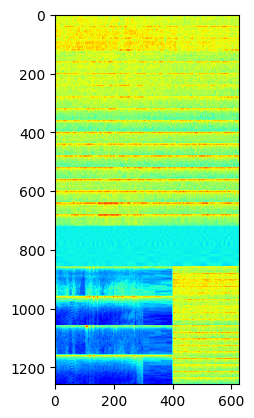

In [15]:
x = next(iter(test_dl))
ic(x['eeg'].dtype)
model = BaseModel()
image = model.preprocess(x)[0]
image = image.detach().cpu().numpy()
ic(image.shape, image.min(), image.max(), image.mean())
plt.imshow(image[0], cmap='jet')

Infer

In [16]:
def iterable(item):
  """
  be careful!  like string 'abc' is iterable! 
  you may need to use if not isinstance(values, (list, tuple)):
  """
  return isinstance(item, Iterable)

def squeeze(x, dim=-1):
  if isinstance(x, (list, tuple)):
    return x
  if len(x.shape) > 1 and x.shape[dim] == 1:
    return x.squeeze(dim)
  return x

class Ensembler(object):

  def __init__(self,
               need_sort=False,
               ignores=['id', 'ids', 'label', 'labels'],
               includes=[],
               id_key='id',
               inplace=True):
    self.x = None
    self.need_sort = need_sort
    self.weights = []
    self.total_weight = 0
    self.ignores = set(ignores)
    self.includes = set(includes)
    self.id_key = id_key
    self.inplace = inplace

  def is_ok(self, key):
    if self.includes:
      return key in self.includes
    return key not in self.ignores

  def add(self, x, weight=1., inplace=True):
    if (not inplace) or (not self.inplace):
      x = x.copy()
    self.total_weight += weight
    if self.need_sort:
      inds = np.asarray(x[self.id_key]).argsort()
      for key in x:
        if (not self.is_ok(key)) and (key != self.id_key):
          continue
        try:
          x[key] = x[key][inds]
        except Exception:
          # ic(key)
          x[key] = [x[key][idx] for idx in inds]

    if self.x is None:
      # 注意这意味着第一个add的输入x 会被改变 如果需要连续使用 比如ensemble-select.py 传递.copy()
      self.x = x
      if iterable(weight) or weight != 1:
        m = {k: [pred * weight for pred in x[k]] for k in x if self.is_ok(k)}
        self.x.update(m)
    else:
      m = {
          k: [pred1 + pred2 * weight for pred1, pred2 in zip(self.x[k], x[k])]
          for k in x
          if self.is_ok(k)
      }
      self.x.update(m)

  def finalize(self):
    x = self.x
    weight = self.total_weight
    for k in x:
      if not self.is_ok(k):
        continue
      x[k] = [pred / weight for pred in x[k]]
    return x

  def adds(self, xs, weights=None, inplace=False):
    if not inplace:
      xs = [x.copy() for x in xs]
    if weights is not None:
      for x, weight in zip(xs, weights):
        self.add(x, weight)
    else:
      for x in xs:
        self.add(x)
    return self.finalize()

def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_weights(model,
                 path,
                 map_location=None,
                 return_checkpoint=False,
                 return_updated=False,
                 renames={},
                 includes=None,
                 excludes=None,
                 to_device=True,
                 eval=True,
                 strict=False):
  checkpoint = torch.load(path, map_location=map_location)
  state = checkpoint['state_dict']
  # https://zhuanlan.zhihu.com/p/601044938
  # 这段代码是在修复checkpoint中的state_dict的key。
  # 在某些情况下，state_dict的key会带有一个"_orig_mod."的前缀，
  # 这段代码就是在遍历state_dict的所有键值对，如果键值对的键以"_orig_mod."开头，
  # 那么就将这个键值对的键去掉"_orig_mod."前缀，并将这个键值对从state_dict中移除。
  unwanted_prefix = '_orig_mod.'
  for k,v in list(state.items()):
    if k.startswith(unwanted_prefix):
      state[k[len(unwanted_prefix):]] = state.pop(k)
      
  # ic(gezi.get_mem_gb())
  model_ = model.module if hasattr(model, 'module') else model
  
  if strict:
    model_.load_state_dict(state, strict=True)
  else:
    full_update = True
    model_state_dict = model_.state_dict()

    def is_ok(key):
      if includes:
        for incl_key in includes:
          if incl_key in key:
            return True
        return False
      if excludes:
        for excl_key in excludes:
          if excl_key in key:
            return False
      return True

    mismatch_ignores = set()
    for key in model_state_dict:
      if key not in state or state[key].shape != model_state_dict[key].shape:
        mismatch_ignores.add(key)
        full_update = False
    if mismatch_ignores:
      ic(mismatch_ignores)
    additional_ignores = set()
    for key in state:
      if key not in model_state_dict:
        additional_ignores.add(key)
        full_update = False
    if additional_ignores:
      ic(additional_ignores)
    if full_update:
      model_.load_state_dict(state)
    else:
      new_params = model_state_dict
      # ic(new_params.keys())
      if not renames:
        new_params.update({
            k: v
            for k, v in state.items()
            if (k in new_params) and (k not in mismatch_ignores) and is_ok(k)
        })
      else:
        ori = list(renames.keys())[0]
        dest = list(renames.values())[0]
        new_params.update({
            k.replace(ori, dest): v
            for k, v in state.items()
            if k.replace(ori, dest) in new_params and
            k.replace(ori, dest) not in mismatch_ignores
        })

      model_.load_state_dict(new_params)

  del checkpoint['state_dict']
  if not return_checkpoint:
    del state
    del checkpoint
    import gc
    gc.collect()

  if to_device:
    device = get_device()
    model.to(device)
  if eval:
    model.eval()

  if not return_checkpoint:
    return

  if not return_updated:
    return checkpoint

  updated_params = []
  for name, param in model_.named_parameters():
    if name in state:
      updated_params.append(param)

  return checkpoint, updated_params

def infer(models,
          inputs,
          weights=None,
          post_fn=None,
          batch_size=None,
          desc='Infering',
          dynamic_keys=[],
          out_keys=[],
          mask_key=None,
          out_hook=None,
          pred_key='pred',
          amp=False,
          fp16=False,
          bfloat16=False,
          verbose=0):
  if not weights:
    weights = [1.] * len(models)
  for i in range(len(models)):
    models[i] = nn.DataParallel(models[i])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    models[i].to(device)
    
    if fp16:
      if not bfloat16:
        models[i].half()
      else:
        models[i] = modeles[i].to(dtype=torch.bfloat16)
    else:
      amp = False
    
  with torch.no_grad():
    input_is_dict = True
    if isinstance(inputs, (list, tuple)):
      if len(inputs) == 2:
        inputs = inputs[0]

    if isinstance(inputs, dict):
      if 0 in inputs:
        return predicts(model, inputs, batch_size, desc, dynamic_keys, mask_key)
      inputs_ = {}
      for key in inputs:
        if (not type(inputs[key][0]) in [np.str_, str]):
          inputs_[key] = inputs[key]
      inputs = inputs_
      # TODO support dynamic length with data collactor padding to max lenght in a batch
      dataset = Dataset.from_dict(inputs)
      dataset.set_format(type='torch', device=device)
      assert batch_size, 'need batch size if your inputs is not dataloader but dict'
      dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    elif isinstance(inputs, pd.DataFrame):
      input_is_dict = True
      dataset = Dataset.from_pandas(inputs)
      dataset.set_format(type='torch', device=device)
      assert batch_size, 'need batch size if your inputs is not dataloader but dict'
      dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    else:
      input_is_dict = False
      dataloader = inputs

    res = None
    first_batch = True
    for inputs in tqdm(dataloader, desc=desc):
      if isinstance(inputs, (list, tuple)):
        if len(inputs) == 2:
          inputs = inputs[0]
      if mask_key is not None:
        max_len = inputs[mask_key].sum(1).max()
        for key in dynamic_keys + [mask_key]:
          if key in inputs:
            inputs[key] = inputs[key][:, :max_len]
      if not input_is_dict:
        for key in inputs:
          if isinstance(inputs[key], torch.Tensor):
            inputs[key] = inputs[key].to(device)
    
      ensembler = Ensembler()
      for i, model in enumerate(models):
        if not amp:
          preds = model(inputs)
        else:
          dtype = torch.float16 if not bfloat16 else torch.bfloat16
          with torch.cuda.amp.autocast(dtype=dtype):
            preds = model(inputs)
          
        if isinstance(preds, dict):
          for key in preds:
            preds[key] = squeeze(preds[key].detach().cpu().numpy())
          
          inputs_ = {k: inputs[k] for k in inputs if k in out_keys}
          for key in inputs_:
            if torch.is_tensor(inputs_[key]):
              inputs_[key] = inputs_[key].detach().cpu().numpy()
          
          if first_batch and verbose > 0:
            ic(i, preds[pred_key][0])
          if out_hook is not None:
            out_hook(preds, inputs_)
          if post_fn is not None:
            preds = post_fn(preds)
            if first_batch and verbose > 0:
              ic(i, preds[pred_key][0])
        else:
          preds = squeeze(preds.detach().cpu().numpy())
          if first_batch and verbose > 0:
            ic(i, preds[0])
          if post_fn is not None:
            preds = post_fn(preds)
            if first_batch and verbose > 0:
              ic(i, preds[0])

        ensembler.add(preds, weights[i])
      preds = ensembler.finalize()
      first_batch = False
      
      if isinstance(preds, dict):
        if not res:
          res = {key: [] for key in preds}
          for key in inputs_:
            res[key] = []
        for key in preds:
          res[key].append(preds[key])
        for key in inputs_:
          res[key].append(inputs_[key])
      else:
        if not res:
          res = []
        res.append(preds)

    if isinstance(res, dict):
      for key in res:
        try:
          res[key] = np.concatenate(res[key])
        except Exception as e:
          # ic(key, e)
          l = []
          for l_ in res[key]:
            l.extend(l_)
          res[key] = l
    else:
      try:
        res = np.contanate(res[key])
      except Exception:
        l = []
        for l_ in res:
          l.extend(l_)
        res = l
    return res
  
def torch_softmax(x, axis=-1):
  return nn.Softmax(dim=axis)(torch.tensor(x)).numpy()

In [17]:
root = FLAGS.model_dir
num_models = int(open(f'{root}/num_models.txt').readline().strip())
ic(num_models)
models = []
for fold in tqdm(range(num_models), desc='folds'):
  model_dir = f'{root}/{fold}'
  model = Model()
  try:
    display(pd.read_csv(f'{model_dir}/metrics.csv'))
    ic(open(f'{root}/path.txt').readline())
  except Exception as e:
    ic(e)
  load_weights(model, f'{model_dir}/model.pt', strict=False)
  models.append(model)

def post_deal(x):
  x['pred'] = list(torch_softmax(np.array(list(x['pred'])).astype(np.float32)))
  return x
x = infer(models, test_dl, post_fn=post_deal, amp=False, fp16=False, verbose=1)

ic| num_models: 6


folds:   0%|          | 0/6 [00:00<?, ?it/s]

ic| e: TypeError("EfficientVit.__init__() got an unexpected keyword argument 'drop_path_rate'")
ic| self.backbone.num_features: 384


,10votes/kl/all,10votes/seizure_rate/all,10votes/other_rate/all,10votes/n_eegs/all,10votes/other/all,10votes/other_label/all,10votes/seizure/all,10votes/seizure_label/all,10votes/entropy/all,10votes/entropy_rate/all,...,all/other_rate/hard,all/other_label/hard,all/seizure/hard,all/seizure_rate/hard,all/seizure_label/hard,all/entropy/hard,all/entropy_rate/hard,all/entropy_label/hard,all/count/hard,all/n_eegs/hard
0,0.396100,1.720952,1.290989,1311.0,0.566669,0.438941,0.095281,0.055364,0.799104,1.216108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.308586,1.030213,1.082014,1311.0,0.474941,0.438941,0.057038,0.055364,0.897126,1.365281,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.249805,1.250369,1.068552,1311.0,0.469032,0.438941,0.069227,0.055364,0.863643,1.314325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.228900,1.105422,1.042426,1311.0,0.457564,0.438941,0.061202,0.055364,0.838630,1.276259,...,1.157822,0.336933,0.107705,1.160521,0.092806,1.113486,1.23507,0.901556,166.0,114.0


ic| open(f'{root}/path.txt').readline(): '../working/76/v9-3.ep-7.efficientvit_b2
                                          '
ic| additional_ignores: {'spec.feature_extractor.window', 'spec2.feature_extractor.window'}
ic| e: TypeError("EfficientVit.__init__() got an unexpected keyword argument 'drop_path_rate'")
ic| self.backbone.num_features: 384


,10votes/kl/all,10votes/seizure_rate/all,10votes/other_rate/all,10votes/n_eegs/all,10votes/other/all,10votes/other_label/all,10votes/seizure/all,10votes/seizure_label/all,10votes/entropy/all,10votes/entropy_rate/all,...,all/other_rate/hard,all/other_label/hard,all/seizure/hard,all/seizure_rate/hard,all/seizure_label/hard,all/entropy/hard,all/entropy_rate/hard,all/entropy_label/hard,all/count/hard,all/n_eegs/hard
0,0.357361,0.736469,1.053844,1137.0,0.496978,0.471585,0.026609,0.036129,0.761342,1.237340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.288441,1.229659,1.208569,1137.0,0.569944,0.471585,0.044428,0.036129,0.813545,1.322181,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.236164,1.118253,1.077662,1137.0,0.508210,0.471585,0.040403,0.036129,0.744365,1.209749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.221750,1.257237,1.007939,1137.0,0.475330,0.471585,0.045424,0.036129,0.791646,1.286591,...,1.035124,0.416474,0.112429,1.475895,0.076176,1.030641,1.223576,0.842318,138.0,100.0


ic| open(f'{root}/path.txt').readline(): '../working/76/v9-3.ep-7.efficientvit_b2
                                          '
ic| additional_ignores: {'spec.feature_extractor.window', 'spec2.feature_extractor.window'}
ic| e: TypeError("EfficientVit.__init__() got an unexpected keyword argument 'drop_path_rate'")
ic| self.backbone.num_features: 384


,10votes/kl/all,10votes/seizure_rate/all,10votes/other_rate/all,10votes/n_eegs/all,10votes/other/all,10votes/other_label/all,10votes/seizure/all,10votes/seizure_label/all,10votes/entropy/all,10votes/entropy_rate/all,...,all/other_rate/hard,all/other_label/hard,all/seizure/hard,all/seizure_rate/hard,all/seizure_label/hard,all/entropy/hard,all/entropy_rate/hard,all/entropy_label/hard,all/count/hard,all/n_eegs/hard
0,0.364850,0.934827,1.233137,1124.0,0.628110,0.509358,0.052878,0.056564,0.803484,1.238484,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.260065,0.728892,1.068422,1124.0,0.544210,0.509358,0.041229,0.056564,0.847613,1.306504,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.238800,1.288635,0.954941,1124.0,0.486408,0.509358,0.072891,0.056564,0.850894,1.311562,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.218510,1.012589,0.997032,1124.0,0.507848,0.509358,0.057277,0.056564,0.814747,1.255846,...,1.025551,0.360076,0.138693,1.167329,0.118812,1.141603,1.226672,0.93065,118.0,83.0


ic| open(f'{root}/path.txt').readline(): '../working/76/v9-3.ep-7.efficientvit_b2
                                          '
ic| additional_ignores: {'spec.feature_extractor.window', 'spec2.feature_extractor.window'}
ic| e: TypeError("EfficientVit.__init__() got an unexpected keyword argument 'drop_path_rate'")
ic| self.backbone.num_features: 384


,10votes/kl/all,10votes/seizure_rate/all,10votes/other_rate/all,10votes/n_eegs/all,10votes/other/all,10votes/other_label/all,10votes/seizure/all,10votes/seizure_label/all,10votes/entropy/all,10votes/entropy_rate/all,...,all/other_rate/hard,all/other_label/hard,all/seizure/hard,all/seizure_rate/hard,all/seizure_label/hard,all/entropy/hard,all/entropy_rate/hard,all/entropy_label/hard,all/count/hard,all/n_eegs/hard
0,0.571643,0.290414,1.398782,1293.0,0.669101,0.478344,0.018208,0.062695,0.529260,0.844952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.327805,0.496792,1.147572,1293.0,0.548935,0.478344,0.031147,0.062695,0.738343,1.178749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.216946,0.792247,1.054825,1293.0,0.504570,0.478344,0.049670,0.062695,0.804100,1.283729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.218652,0.869054,1.058389,1293.0,0.506275,0.478344,0.054486,0.062695,0.771935,1.232378,...,1.374205,0.272659,0.106955,1.043988,0.102448,1.027835,1.151908,0.892288,271.0,150.0


ic| open(f'{root}/path.txt').readline(): '../working/76/v9-3.ep-7.efficientvit_b2
                                          '
ic| additional_ignores: {'spec.feature_extractor.window', 'spec2.feature_extractor.window'}
ic| e: TypeError("EfficientVit.__init__() got an unexpected keyword argument 'drop_path_rate'")
ic| self.backbone.num_features: 384


,10votes/kl/all,10votes/seizure_rate/all,10votes/other_rate/all,10votes/n_eegs/all,10votes/other/all,10votes/other_label/all,10votes/seizure/all,10votes/seizure_label/all,10votes/entropy/all,10votes/entropy_rate/all,...,all/other_rate/hard,all/other_label/hard,all/seizure/hard,all/seizure_rate/hard,all/seizure_label/hard,all/entropy/hard,all/entropy_rate/hard,all/entropy_label/hard,all/count/hard,all/n_eegs/hard
0,0.347653,1.035053,1.032884,1074.0,0.508568,0.492376,0.038595,0.037287,0.959603,1.476302,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.325504,0.899580,1.024447,1074.0,0.504414,0.492376,0.033544,0.037287,0.793763,1.221165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.233826,0.744023,1.058513,1074.0,0.521187,0.492376,0.027743,0.037287,0.822637,1.265587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.222506,1.054670,1.048073,1074.0,0.516047,0.492376,0.039327,0.037287,0.825562,1.270087,...,1.18377,0.310877,0.137437,1.012188,0.135782,1.026387,1.199791,0.85547,193.0,111.0


ic| open(f'{root}/path.txt').readline(): '../working/76/v9-3.ep-7.efficientvit_b2
                                          '
ic| additional_ignores: {'spec.feature_extractor.window', 'spec2.feature_extractor.window'}
ic| e: TypeError("EfficientVit.__init__() got an unexpected keyword argument 'drop_path_rate'")
ic| self.backbone.num_features: 384


,10votes/kl/all,10votes/seizure_rate/all,10votes/other_rate/all,10votes/n_eegs/all,all/kl/all,all/other/all,all/other_rate/all,all/other_label/all,all/seizure/all,all/seizure_rate/all,...,10votes/count/hard,10votes/n_eegs/hard,train_loss,val_time,loss,val_loss,epoch,insts,step,ntime
0,0.153191,1.033794,0.993102,1311.0,0.153191,0.435913,0.993102,0.438941,0.057236,1.033794,...,166,114.0,0.174882,0.26814,0.174882,0.151222,7.0,1374,1,2024-04-15 08:20:21


ic| open(f'{root}/path.txt').readline(): '../working/76/v9-3.ep-7.efficientvit_b2
                                          '
ic| additional_ignores: {'spec.feature_extractor.window', 'spec2.feature_extractor.window'}


Infering:   0%|          | 0/1 [00:00<?, ?it/s]

ic| i: 0
    preds[pred_key][0]: array([-0.6992075,  0.8537583, -4.474362 ,  2.9640207, -0.3501093,
                                2.9133008], dtype=float32)
ic| i: 0
    preds[pred_key][0]: array([1.2017486e-02, 5.6788199e-02, 2.7560361e-04, 4.6852571e-01,
                               1.7038250e-02, 4.4535470e-01], dtype=float32)
ic| i: 1
    preds[pred_key][0]: array([-0.24568635,  0.69206095, -5.3660774 ,  3.471798  , -0.9310478 ,
                                3.3077583 ], dtype=float32)
ic| i: 1
    preds[pred_key][0]: array([1.2475321e-02, 3.1864725e-02, 7.4523647e-05, 5.1349312e-01,
                               6.2864134e-03, 4.3580592e-01], dtype=float32)
ic| i: 2
    preds[pred_key][0]: array([-0.9749922 ,  0.12859282, -5.644602  ,  2.6384192 , -0.5352874 ,
                                2.3844445 ], dtype=float32)
ic| i: 2
    preds[pred_key][0]: array([1.3997381e-02, 4.2201478e-02, 1.3123846e-04, 5.1919609e-01,
                               2.1727420e-02, 4.0274635e-

In [18]:
TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
sub = pd.DataFrame({'eeg_id': test.eeg_id.values})
sub[TARGETS] = x['pred'][:len(test)]
sub.to_csv('submission.csv',index=False)
print(f'Submissionn shape: {sub.shape}')
sub.head()

Submissionn shape: (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.016849,0.054699,0.000141,0.47374,0.016867,0.437704
